# Implementación de algoritmo genético para optimizar la ubicación de los productos en el almacén
---

En este problema se implementó un algoritmo genético para resolver el problema de optimización de la ubicación de los productos en un layout definido del almacen, de tal forma de optimizar el picking para un conjunto de ordenes de productos habituales.

## Análisis del algoritmo

El algoritmo es más específicamente un algoritmo genético con permutaciones. Para la implementación fue necesario predifinir diferentes etapas:

- **Individuos**:

A la hora de definir individuos se decidió hacer una especie de "mapeo" sobre el layout original. Es decir, si el layout es para 32 productos, cada individuo será una lista de números de 0 a 31 ordenados de tal manera que el índice dará su posición. Por ejemplo, si un individuo es [5, 2, 4, 0, 1, 3] el producto 5 estará ubicado donde antes estaba el producto 0.

- **Función de fitness**:

Para calcular el fitness de un determinado individuo, se realiza un **recocido simulado** (ya implementado en el ejercicio anterior) para cada orden en el conjunto de órdenes habituales, para las cuales se desea optimizar la ubicación de los productos. Si recordamos, la función donde se implementó el recocido simulado recibe como parámetros la lista de productos a recolectar, la temperatura inicial, la función de generación de vecinos y la heurística a utilizar. Debido a que el objetivo del algoritmo genético es justamente cambiar la ubicación de los productos en el almacen, y el recocido simulado se ejecuta para el layout original, en lugar de pasar el número de producto en la secuencia, se pasa su índice en la lista (que es en definitiva el lugar donde se encuentra).

Entonces, para cada orden del conjunto se ejecuta el recocido simulado, que a su vez ejecuta internamente el algoritmo **A***. Como resultado se obtiene el costo de camino para esa orden, dada el layout que es el individuo, y con el picking optimizado por el recocido simulado. En teoría, es el menor costo posible al buscar todos los productos de la orden en éste layout.

El fitness final del individuo será un promedio de los costos para cada orden.

- **Selección**:

A la hora de elegir un individuo de la población previo al *crossover*, se utilizó **roulette wheel selection**. La idea general es que la selección es aleatoria pero los individuos tienen mayor probabilidad de ser elegidos cuanto menor sea su *fitness* (recuerdese que lo que se desea es minimizar el costo de *picking*).

- **Crossover**:

Se eligió **cruce de orden** como procedimiento de cruce por ser apto para algoritmos genéticos de permutación. Consiste en seleccionar dos puntos de cruce al azar, se copian los elementos de los padres entre los puntos de cruce, cruzados, y luego se copian los valores restantes a partir del segundo corte, en orden, evitando duplicar valores.

- **Mutación**:

Se eligió **inserción** también por ser apto para el problema de permutaciones. Consiste en elegir 2 genes al azar de la solución, se mueve el segundo gen elegido a continuación del primero y el resto de los genes se mueven a la derecha.

- **Condición de corte**:

La condición de corte del algoritmo es por cantidad de iteraciones (generaciones), y no por convergencia.


## Evaluación de rendimiento del algoritmo

## Reducción de *fitness*

La primer evaluación que se realizó, y más intuitiva, fue la reducción del fitness del mejor individuo de la población a lo largo de las generaciones (iteraciones) del algoritmo.

Se creó un conjunto de ordenes aleaorias (conjunto para el cuál se debe optimizar el almacén), de tal forma que ciertos productos tengan una mayor tendencia a aparecer. Esto es a modo de evaluación visual, intuyendo que los productos que más se repiten tenderían a aparecer ubicados más cercas de donde se comienza el *picking*.

In [1]:
from genetic import genetic, generate_ind
from matplotlib import pyplot as plt
from random import randint, choices

N_POB = 10 # Cantidad de individuos en la población
MAX_LENGHT = 32 # Cantidad de estanterías
T_0 = 200 # Temperatura inicial a la que inicia el algoritmo de temple simulado
MAX_GEN = 50 # Máxima cantidad de iteraciones a la que corta el algoritmo genético

In [2]:
conjunto = []

prob = []

estant = [i for i in range(0, MAX_LENGHT)]

for i in range(0, 25):
    prob.append(0.1)

for i in range(25, MAX_LENGHT):
    prob.append(0.5)

for i in range(0, 8):
    conjunto.append(choices(population=estant, k=randint(3, 7), weights=prob))

print(conjunto)

[[22, 29, 29], [28, 31, 29, 29, 9], [30, 26, 4, 6, 31], [6, 27, 4, 29], [24, 31, 29, 30, 31, 27, 15], [14, 29, 30, 31, 27, 27], [26, 4, 27, 22, 31, 30], [29, 30, 26]]


[[26, 8, 29, 20, 17, 24, 30, 4, 25, 18, 27, 13, 10, 15, 5, 7, 31, 9, 2, 28, 14, 21, 3, 11, 6, 19, 23, 1, 12, 16, 22, 0], 1.0]


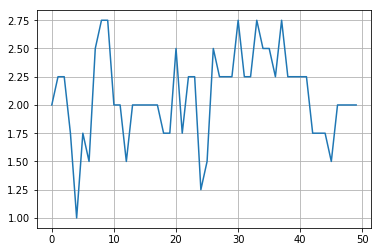

In [5]:
start = []
for i in range(0, N_POB):
    start.append(generate_ind())

best, history = genetic(start, conjunto, hist=True, status=False)
print(best)

plt.plot(history)
plt.grid()

Como se puede observar en el gráfico, esta manera de evaluar no da resultados conclusivos del funcionamiento del algoritmo, esto podría deberse a que la diferencia de *fitness* entre el estado inicial y el óptimo no es la suficiente y al alcanzarse un mínimo este *fitness* comienza a oscilar.

## Comparación de costos con layout optimizado y sin optimizar

Dado que el análisis anterior no brinda resultados determinantes sobre el rendimiento y funcionamiento del algoritmo, se buscó otra forma de verificar que el algoritmo efectivamente funciona.

Se plantea ejecutar el recocido simulado para una determinada orden de productos de tal forma de optimizar la secuencia del *picking* esté optimizada para el layout original del almacén. Luego ejecutar el algoritmo genético para obtener el layout óptimo para dicha orden de productos. Y por último, ejecutar el recocido simulado para la misma orden pero esta vez con el layout del almacén optimizado.

In [6]:
from simulated_annealing import map_to_coord, temple_simulado, neighbours_annealing, distance

In [7]:
cost0 = []
cost1 = []

for orden in conjunto:
    coordenadas = map_to_coord(orden)
    _, costo = temple_simulado(coordenadas, 200, neighbours_annealing, distance)
    cost0.append(costo)
    
    # Generación de población inicial
    start = []
    for i in range(0, N_POB):
        start.append(generate_ind())
    
    new_layout, _ = genetic(start, [orden], status=False)
    
    orden_estant = []
    for prod in orden:
        orden_estant.append(new_layout.index(prod))
    
    coordenadas = map_to_coord(orden_estant)
    _, costo = temple_simulado(coordenadas, 200, neighbours_annealing, distance)
    cost1.append(costo)
    

/run/media/emiliano/Gorrion Supremo/Documentos/Facultad/Inteligencia Artificial 2/ia2/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/run/media/emiliano/Gorrion Supremo/Documentos/Facultad/Inteligencia Artificial 2/ia2/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/run/media/emiliano/Gorrion Supremo/Documentos/Facultad/Inteligencia Artificial 2/ia2/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 's' instances.
A proxy artist may b

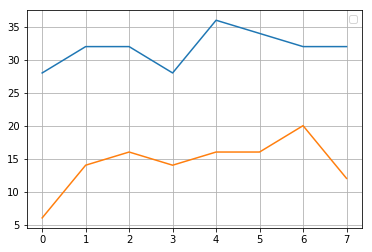

In [8]:
plt.plot(cost0)
plt.plot(cost1)
plt.legend("costo con layout sin optimizar", "costo con layout optimizado")
plt.grid()

In [18]:
avg = 0
for i, j in zip(cost0, cost1):
    avg += (i - j) / i
avg = avg * 100 / len(cost0)

print(avg)

56.275638544891635


En el gráfico anterior pueden observarse diferencias claras al optimizar la ubicación de los productos en el almacen para un conjunto de ordenes, por lo que puede concluirse que el algoritmo está funcionando correctamente, reduciendo costos en aproximadamente **56,27%**.

## Análisis de la probabilidad de mutación

A continuación se realiza un análisis para encontrar un valor aceptable de probabilidad de mutación. Esto se obtiene ejecutando el análisis anterior y comparando la reducción promedio obtenida del conjunto de ordenes.

In [4]:
ans = []

mut_prob = list(range(0, 55, 5))

for m in mut_prob:
    cost0 = []
    cost1 = []

    for orden in conjunto:
        coordenadas = map_to_coord(orden)
        _, costo = temple_simulado(coordenadas, 200, neighbours_annealing, distance)
        cost0.append(costo)

        # Generación de población inicial
        start = []
        for i in range(0, N_POB):
            start.append(generate_ind())

        new_layout, _ = genetic(start, [orden], mut=m, status=False)

        orden_estant = []
        for prod in orden:
            orden_estant.append(new_layout.index(prod))

        coordenadas = map_to_coord(orden_estant)
        _, costo = temple_simulado(coordenadas, 200, neighbours_annealing, distance)
        cost1.append(costo)
    
    avg = 0
    for i, j in zip(cost0, cost1):
        avg += (i - j) / i
    avg = avg * 100 / len(cost0)

    ans.append(avg)

KeyboardInterrupt: 